# Homework 2 (HW2)
By the end of this homework, we expect you to be able to:

- Preprocess data and make it amenable to statistical analysis and machine learning models;
- Train and test out-of-the-box machine learning models in Python;
- Carry out simple multivariate regression analyses;
- Use techniques to control for covariates;
- Conduct an observational study and reason about its results.

---

- Homework release: Fri 17 Nov 2023	

- **Homework Due**: Fri 01 Dec 2023, 23:59	

- Grades released: Mon 11 Dec 2023	


---

## Some rules
1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you may do so, but must justify your choice.

2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you don’t change any of the files.)

3. Be sure to provide a concise textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice.

4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation **(in markdown)**.

5. Back up any hypotheses and claims with data, since this is an important aspect of the course.

6. Please write all your comments in **English**, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the master/main branch. **If there are multiple notebooks present, we will not grade anything.**

7. We will **not run your notebook for you!** Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.

8. In continuation to the previous point, interactive plots, such as those generated using the `plotly` package, should be strictly avoided!

9. Make sure to print results and/or dataframes that confirm you have properly addressed the task.


---

In [1]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx

# machine lerning
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_columns', None)


## Context

After two years, the EPFL Baseball Club is broke. The new Dean transferred all funds to EPFL's new poster child: its super-competitive Pétanque club. After struggling so much to learn about baseball, you have unfortunately been laid off...

*(...) 1 month after, you manage to get another job (!) (...)*

Congratulations! You have just been hired as a data scientist at the Association for Computational Linguistics (ACL), a professional organization for people working on natural language processing. The ACL organizes several of the top conferences and workshops in the field of computational linguistics and natural language processing.
Your boss, Dr. Tiancheng, knows of your expertise in observational studies and asks you to investigate a question that’s been bothering everyone who has ever submitted a paper to a conference: should I spend time on writing rebuttals?



---

## Rebuttals, conferences, and getting your papers accepted

Rebuttals in ACL (Association for Computational Linguistics) conferences and in many other academic conferences are an important part of the peer-review process. They allow authors of submitted papers to respond to the reviews and comments provided by the reviewers before a final decision is made regarding the acceptance of the paper. Here's how the rebuttal process typically works in ACL conferences:

- Paper Submission: Authors submit their research papers to the ACL conference for review. These papers present novel research findings in computational linguistics, natural language processing, and related areas.
- Peer Review: The papers undergo a peer-review process after the initial submission. The program committee or reviewers are experts in the field who evaluate the papers based on their quality, significance, novelty, methodology, and other relevant criteria. They provide comments and scores for each paper.
- Rebuttal Period: After receiving the reviews, authors are given a specific period (usually around a week) to write a rebuttal. The rebuttal is a formal response to the reviewers' comments. It allows authors to clarify misunderstandings, address concerns, and provide additional information to support their paper's quality. 
- Final Review: After receiving the rebuttals, the reviewers may reconsider their initial assessments in light of the authors' responses. Reviewers may choose to maintain or adjust their reviews and scores based on the quality and effectiveness of the author's rebuttal.
- Final Decision: The program committee or conference organizers consider the initial reviews/scores, rebuttals, and revised reviews/scores to make a final decision on the acceptance of the papers. The decision can be acceptance, rejection, or conditional acceptance with a request for revisions.


---

## Data

- `tmp_id`: Unique identifier for each paper in the format "P{number}".
- `status`: Accept or Reject.
- `submission_type`: Short vs. Long (papers can have different lengths). We do not use this column in this homework. 
- `track`: Track to which the paper was submitted, broadly speaking, the "topic" of the paper.
- `scores_before`: Scores received before rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework. 
- `scores_after`: Scores received after rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework.
- `had_rebuttal`: True or False.


Note that: 
 - reviews are assigned numbers, e.g., "2";
 - papers can have different numbers of reviews;
 - review numbers are arbitrary, e.g., `P1` in the dataframe has two reviews numbered "2" and "3" (but no review "1").


In [2]:
# Read the .json file and create a dataframe
df = pd.read_json('./data/acl18_v1_numerical_final.json')

#drop column submission_type
df = df.drop(columns=['submission_type'])

df['scores_before'] = df['scores_before'].apply(lambda x : {key: value['scores']['overall_score'] for key, value in x.items()})
df['scores_after'] = df['scores_after'].apply(lambda x : {key: value['scores']['overall_score'] for key, value in x.items()})
print(df.shape)

(1538, 6)


## Task 1 (10 pts): Get to Know Your Data

As a good data scientist, you first load the data and perform some small sanity checks on it.

- You are expected to continuously alter your dataframe as you complete the tasks. E.g., if you are asked to filter the data in a specific task, continue using the filtered dataset in the subsequent tasks.
- When we tell you to "print the dataframe," make sure you print it in a way that shows the total number of rows and columns in it (`display(df)` should suffice).

**1.1** Load the dataset containing ACL reviews into memory using pandas. 
- For each paper, create columns `overall_score_before_avg` and `overall_score_after_avg` containing the average (overall) scores before and after rebuttal.
- For each paper, create columns `overall_score_before_std` and `overall_score_after_std` containing the standard deviation of the overall scores before and after the rebuttal.
- Print the four newly created columns for paper `P17`.
- Print the resulting dataframe.

In [3]:
df['overall_score_before_avg'] = df['scores_before'].apply(lambda x: np.mean(list(x.values())))
df['overall_score_before_std'] = df['scores_before'].apply(lambda x: np.std(list(x.values())))
df['overall_score_after_avg'] = df['scores_after'].apply(lambda x: np.mean(list(x.values())))
df['overall_score_after_std'] = df['scores_after'].apply(lambda x: np.std(list(x.values())))


**1.2** Create a single plot with 14 inches of width and 4 inches of height. The plot should contain two panels: 
- **Panel A**: The distribution of `overall_score_before_avg` for papers that were accepted and papers that were rejected.
- **Panel B**: The distribution of `overall_score_before_avg` for papers that had rebuttals vs. papers that did not.

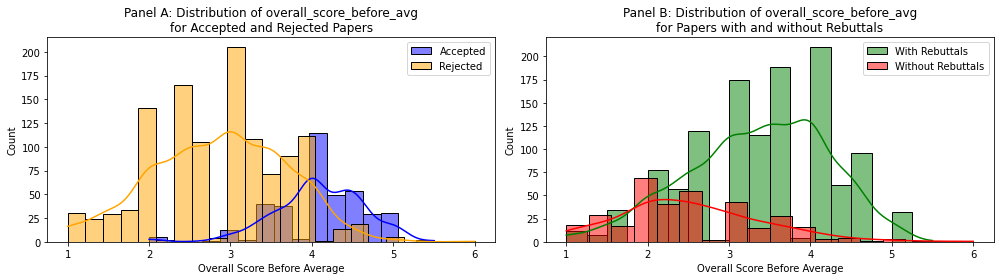

In [4]:
plt.figure(figsize=(14, 4))

# Panel A: Distribution of overall_score_before_avg for accepted and rejected papers
plt.subplot(1, 2, 1)
accepted_data = df[df['status'] == 'Accept']['overall_score_before_avg']
rejected_data = df[df['status'] == 'Reject']['overall_score_before_avg']
sns.histplot(data=accepted_data, kde=True, label='Accepted', color='blue', alpha=0.5)
sns.histplot(data=rejected_data, kde=True, label='Rejected', color='orange', alpha=0.5)
plt.title('Panel A: Distribution of overall_score_before_avg\nfor Accepted and Rejected Papers')
plt.xlabel('Overall Score Before Average')
plt.ylabel('Count')
plt.legend()

# Panel B: Distribution of overall_score_before_avg for papers with and without rebuttals
plt.subplot(1, 2, 2)
with_rebuttals_data = df[df['had_rebuttal'] == 1]['overall_score_before_avg']
without_rebuttals_data = df[df['had_rebuttal'] == 0]['overall_score_before_avg']
sns.histplot(data=with_rebuttals_data, kde=True, label='With Rebuttals', color='green', alpha=0.5)
sns.histplot(data=without_rebuttals_data, kde=True, label='Without Rebuttals', color='red', alpha=0.5)
plt.title('Panel B: Distribution of overall_score_before_avg\nfor Papers with and without Rebuttals')
plt.xlabel('Overall Score Before Average')
plt.ylabel('Count')
plt.legend()
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

**1.3** **/Discuss/:** If you know a paper had a rebuttal, is it more or less likely that it was accepted? Does this mean that rebuttals help papers get accepted? Explain why or why not, providing a concrete example.

- **E(overall score before avarage|with rebuttals) > E(overall score before avarage|without rebuttals)**

- This is the information we get from pannel B. Pannel A on the other hand, gives us the notion of **higer avg before rebutal => higher chances to get accepted**. Thus, having the inforrmation that a paper had a rebutal could indicate that it is more likeley to be rated high and thus more likeley to be accepted.

- This doesn't directly prove that rebuttles help papers get accepted. As we can see from Panel B, the papers that tend to have rebuttles are those that are rated well enough to start with. Those that don't gete poor scores and most likeley prefer rewriting the paper and trying their luck next time. Thus, the presence of a rebuttle is a way, an indicator of the confidence of a papers autor in their own work.

**1.4** Print the percentage of rebuttals per track in the conference (defined by the `track` column). 

**/Discuss:/** Using "the logic" of hypothesis testing (see slide 29 of Lecture 4), how would you devise a statistical test to refute the following null hypothesis: all tracks have the same fraction of papers with rebuttals. Your statistical test should consider all categories at once, rather than comparing the fraction of rebuttals between pairs of categories.

In [5]:
df_rebuttal = df[df['had_rebuttal'] == 1]
df_rebutal_perc_track = df_rebuttal['track'].value_counts() / df['track'].value_counts()
df_rebutal_perc_track

Dialogue and Interactive Systems                                0.775281
Discourse and Pragmatics                                        0.804348
Document Analysis                                               0.730000
Generation                                                      0.779661
Information Extraction and Text Mining                          0.768362
Linguistic Theories Cognitive Modeling and Psycholinguistics    0.750000
Machine Learning                                                0.808696
Machine Translation                                             0.820755
Multidisciplinary and Area Chair COI                            0.680000
Multilinguality                                                 0.806452
Phonology Morphology and Word Segmentation                      0.851852
Question Answering                                              0.728395
Resources and Evaluation                                        0.732394
Sentence-level semantics                           

- Compare one by one, filtering out the data being compared (?)

## Task 2 (10pts): Prediction

You decide to investigate further the effect of rebuttals on acceptance using your machine learning skills.


**2.1** For each possible value in the `track` column, create a new column called {track}-onehot (e.g., for track=Generation, create Generation-onehot). Collectively, these new columns should "one hot-encode" the track column---for instance, if for a given paper the `track` column is filled with the value "Generation", the Generation-onehot column should equal 1 and all other {track}-onehot columns should equal 0. 

Print the column names of the resulting dataframe.

In [6]:
#use one hot encoding to encode the categorical variables found in column track, naming the new columns as <track_name>-onehot
df_encoded = pd.get_dummies(df['track'], prefix='', prefix_sep='')

# Rename the columns
df_encoded.columns = [f"{col}-onehot" for col in df_encoded.columns]

# Concatenate the original DataFrame with the encoded columns
df_one_hot = pd.concat([df, df_encoded], axis=1)

In [7]:
df_one_hot.sample(2)

,tmp_id,status,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_before_std,overall_score_after_avg,overall_score_after_std,Dialogue and Interactive Systems-onehot,Discourse and Pragmatics-onehot,Document Analysis-onehot,Generation-onehot,Information Extraction and Text Mining-onehot,Linguistic Theories Cognitive Modeling and Psycholinguistics-onehot,Machine Learning-onehot,Machine Translation-onehot,Multidisciplinary and Area Chair COI-onehot,Multilinguality-onehot,Phonology Morphology and Word Segmentation-onehot,Question Answering-onehot,Resources and Evaluation-onehot,Sentence-level semantics-onehot,Sentiment Analysis and Argument Mining-onehot,Social Media-onehot,Summarization-onehot,Tagging Chunking Syntax and Parsing-onehot,Textual Inference and Other Areas of Semantics-onehot,Vision Robotics Multimodal Grounding and Speech-onehot,Word-level Semantics-onehot
771,P772,Reject,Word-level Semantics,"{'1': 4, '3': 4}","{'1': 4, '3': 4}",True,4.0,0.0,4.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
498,P499,Reject,Document Analysis,{'1': 1},{'1': 1},False,1.0,0.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



**2.2** Create a column `had_rebuttal_int`, which equals 1 if the paper had a rebuttal, and 0 otherwise, and a column `accepted_int`, which equals 1 if the paper was accepted, and 0 otherwise. 

In [8]:
df_one_hot['accepted_int'] = df_one_hot['status'].apply(lambda x: 1 if x == 'Accept' else 0)
df_one_hot['had_rebuttal_int'] = df_one_hot['had_rebuttal'].apply(lambda x: 1 if x == True else 0)
df_one_hot.sample(2)

,tmp_id,status,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_before_std,overall_score_after_avg,overall_score_after_std,Dialogue and Interactive Systems-onehot,Discourse and Pragmatics-onehot,Document Analysis-onehot,Generation-onehot,Information Extraction and Text Mining-onehot,Linguistic Theories Cognitive Modeling and Psycholinguistics-onehot,Machine Learning-onehot,Machine Translation-onehot,Multidisciplinary and Area Chair COI-onehot,Multilinguality-onehot,Phonology Morphology and Word Segmentation-onehot,Question Answering-onehot,Resources and Evaluation-onehot,Sentence-level semantics-onehot,Sentiment Analysis and Argument Mining-onehot,Social Media-onehot,Summarization-onehot,Tagging Chunking Syntax and Parsing-onehot,Textual Inference and Other Areas of Semantics-onehot,Vision Robotics Multimodal Grounding and Speech-onehot,Word-level Semantics-onehot,accepted_int,had_rebuttal_int
933,P934,Accept,Social Media,"{'1': 4, '2': 2}","{'1': 4, '2': 4}",True,3.0,1.000000,4.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1
94,P95,Reject,Vision Robotics Multimodal Grounding and Speech,"{'1': 3, '2': 2, '3': 4}","{'1': 3, '2': 2, '3': 3}",True,3.0,0.816497,2.666667,0.471405,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


**2.3** Create a function `numpy_helper(df, cols)` to obtain a numpy.array out of your dataframe. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension `(NxM)` cast as a float.

In [9]:
def numpy_helper(df, cols):
    # Select the specified columns from the dataframe
    selected_df = df[cols]
    
    # Convert the selected dataframe to a numpy array and cast it as float
    numpy_array = selected_df.to_numpy(dtype=float)
    
    return numpy_array



**2.4**
Create:
- an array of features X containing all track one-hot features, as well as the `overall_score_before_avg`,`overall_score_before_std`, and `had_rebuttal_int`;
- an array of outcomes y containing `accepted_int`. 


Print the shapes of both X and y (e.g., `X.shape`).

In [10]:
one_hot_cols = [col for col in df_one_hot.columns if '-onehot' in col]
features = ['overall_score_before_avg', 'overall_score_before_std', 'had_rebuttal_int'] + one_hot_cols
X = numpy_helper(df_one_hot, features)
y = numpy_helper(df_one_hot, ['accepted_int'])
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (1538, 24)
y shape: (1538, 1)



**2.5** Build two `GradientBoostingClassifier` models using `sklearn` using the default parameters:
- Model 1: predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std`.
- Model 2:  predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std` **and** `had_rebuttal_int`.


For both models:

- Use the `cross_validate` function from `sklearn.model_selection` to compute the average precision, recall, and accuracy across test cross validation splits.

    - e.g., `cross_validate(clf, X, y, cv=30, scoring=('accuracy', 'precision', 'recall'))`

In [11]:
def grad_boost_clf(df, cols):
    X,y = df[cols], df['accepted_int'].ravel()
    clf = GradientBoostingClassifier()
    return cross_validate(clf, X, y, cv=30, scoring=['accuracy', 'precision', 'recall', 'f1'],return_train_score=True)

def print_results(cv_results):
    for metric in cv_results.keys():
        print(f"{metric}: {cv_results[metric].mean()} (std: {cv_results[metric].std()})")

In [12]:
one_hot_cols = [col for col in df_one_hot.columns if '-onehot' in col]
features_base = ['overall_score_before_avg', 'overall_score_before_std'] + one_hot_cols
features_dev = ['had_rebuttal_int'] + features_base

cv_results_base = grad_boost_clf(df_one_hot, features_base)
cv_results_dev = grad_boost_clf(df_one_hot, features_dev)

In [13]:
print("Model 1:")
print_results(cv_results_base)
print()
print("Model 2:")
print_results(cv_results_dev)

Model 1:
fit_time: 0.180503511428833 (std: 0.059925440592484586)
score_time: 0.006032721201578776 (std: 0.0023112015408422244)
test_accuracy: 0.8373303167420816 (std: 0.040621741013475474)
train_accuracy: 0.8675171510350057 (std: 0.00204333241782293)
test_precision: 0.7085207385207386 (std: 0.11744279655723296)
train_precision: 0.7786651538410765 (std: 0.006514229984411329)
test_recall: 0.592948717948718 (std: 0.11531039873360703)
train_recall: 0.6461644406724142 (std: 0.012042509585537734)
test_f1: 0.6392412910986518 (std: 0.10062207915636157)
train_f1: 0.7061567756533975 (std: 0.006449265958890717)

Model 2:
fit_time: 0.14457887013753254 (std: 0.032938511088940366)
score_time: 0.004922342300415039 (std: 0.0007337996980534169)
test_accuracy: 0.8386500754147814 (std: 0.03711351720402857)
train_accuracy: 0.8679206781790322 (std: 0.002090118772956439)
test_precision: 0.7126813001813002 (std: 0.1079234768368986)
train_precision: 0.779642822018811 (std: 0.00827298094817993)
test_recall: 0.


**2.6** Determine whether the difference in accuracy of the two models is statistically significant.


In [14]:
print("Model 1 accuracy: ", cv_results_base['test_accuracy'].mean())
print("Model 2 accuracy: ", cv_results_dev['test_accuracy'].mean())
#do t test to see if the difference in accuracy is significant
from scipy.stats import ttest_ind
coef, p_val = ttest_ind(cv_results_base['test_accuracy'], cv_results_dev['test_accuracy'])
print("p-value: ", p_val)

Model 1 accuracy:  0.8373303167420816
Model 2 accuracy:  0.8386500754147814
p-value:  0.897673080747567


We can see that the mean of cross vlaidation accuracies are near identical, to prove the resemblance of these numbers, we could conduct a t-test on the accuracy values obtained and find that not only are the means similar, but p-value = 0.89 founding that the null hypothesis (these are identical distributions) holds well.

**2.7** **/Discuss:/** Contrast the results obtained in **2.6** with what you observed in **Task 1**. What advantage did the analyses in **2.6** have?

- In task one we gained an insight on the correlation between the number of points scored and the ditribution on the possibility of having your paper accepted. However there was a lot of **overlaping** in the graphs. 

- This time we have the knowledge of the domain in which the paper has been written and can thus add the domain specific information obtained this way. 
- We see that the fact of having a rebutal or **not doesn't exactly change** the decision accuracy afteer all, proving that is actually **not an important feature** and could be discarded (at least when working with a gradient booster classifier) 

## Task 3 (12pts): Interlude



**3.1** Using the formula API from `statsmodels`, estimate the following linear regressions. Report the summary of the models.
- `accepted_int ~ had_rebuttal_int`,  
- `accepted_int ~ overall_score_after_avg`
- `had_rebuttal_int ~ overall_score_before_avg`

In [15]:
# Model 1: accepted_int ~ had_rebuttal_int
model_1 = smf.ols('accepted_int ~ had_rebuttal_int', data=df_one_hot)
result_1 = model_1.fit()

# Model 2: accepted_int ~ overall_score_after_avg
model_2 = smf.ols('accepted_int ~ overall_score_after_avg', data=df_one_hot)
result_2 = model_2.fit()

# Model 3: had_rebuttal_int ~ overall_score_before_avg
model_3 = smf.ols('had_rebuttal_int ~ overall_score_before_avg', data=df_one_hot)
result_3 = model_3.fit()

In [16]:
# Display model summaries
print("Model 1: accepted_int ~ had_rebuttal_int")
print("dependance of acceptance on rebuttal")
print(result_1.summary())


Model 1: accepted_int ~ had_rebuttal_int
dependance of acceptance on rebuttal
                            OLS Regression Results                            
Dep. Variable:           accepted_int   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     66.22
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           8.24e-16
Time:                        21:28:24   Log-Likelihood:                -855.16
No. Observations:                1538   AIC:                             1714.
Df Residuals:                    1536   BIC:                             1725.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [17]:
print("\nModel 2: accepted_int ~ overall_score_after_avg")
print("dependance of acceptance on overall score after rebuttal")
print(result_2.summary())


Model 2: accepted_int ~ overall_score_after_avg
dependance of acceptance on overall score after rebuttal
                            OLS Regression Results                            
Dep. Variable:           accepted_int   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     1031.
Date:                Tue, 21 Nov 2023   Prob (F-statistic):          1.58e-173
Time:                        21:28:24   Log-Likelihood:                -492.65
No. Observations:                1538   AIC:                             989.3
Df Residuals:                    1536   BIC:                             1000.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------

In [18]:
print("\nModel 3: had_rebuttal_int ~ overall_score_before_avg")
print("dependance of rebuttal on score before rebuttal")
print(result_3.summary())


Model 3: had_rebuttal_int ~ overall_score_before_avg
dependance of rebuttal on score before rebuttal
                            OLS Regression Results                            
Dep. Variable:       had_rebuttal_int   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     240.2
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           1.89e-50
Time:                        21:28:24   Log-Likelihood:                -727.42
No. Observations:                1538   AIC:                             1459.
Df Residuals:                    1536   BIC:                             1470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------


**3.2** **/Discuss:/** Interpret the coefficients associated with the binary independent variable in the above models. Note that independent variables are the ones on the right-handside of the equation.

- e.g., in `had_rebuttal_int ~ overall_score_before_avg`, `overall_score_before_avg` is the independent variable.



- Model 1: accepted_int =  0.2098 * had_rebuttal_int + 0.0838
- The only model out of the three that uses a binary independant vatiable is the first one. We see in the equation above that the fact of having a rebuttal seems to add on its own a 0.2 = 1/5 chance of having the paper accepted.


- Model 3: had_rebuttal_int = 0.1651 * overall_score_before_avg + 0.2527


**3.3** **/Discuss:/** describe three correlations you can draw from the previous analysis. Describe their sign (i.e., whether they are positive or negative), and whether they are statistically significant (at the .05 level of significance).


- all corelations seem to be positive

- in addition to that, the p values of the coeficients apear to be very close to zero, thus indicating that these coeficients are of statistically significant value. 

- as said in the previous answer, the coeficient of having a rebuttal is 0.2 and the intercept here is 0.08, signifying a measurrable difference, having a rebuttal or not. Yet still having the final value not exeeding 0.3 which indicates a probabilaty of rather not being accepted than accepted. 

- Model 2: accepted_int = 0.2860 * overall_score_after_avg - 0.6558 
for model 2, we see that the intercept term is negative, of -0.65. In the same time, the coef associated with the score obtained is 0.28. Together this would mean that at a score of 5/5 we are yet to reach 1 but find the value of 0.7742. Overall, this shows that even though the acceptance is even more correlated with a high score, there are other factors to count for. 

- Model 3: had_rebuttal_int = 0.1651 * overall_score_before_avg + 0.2527
Finally, in this model, the intercept value of 0.25 indicates that even with a low score,thre is a probabilaty of having a rebuttal. As sujested earlier (in part 1), reebuttals seemed to occur more often together with higher scores and this is exactly the tendancy that's proved by the posititve coeficient of overall_score_before_avg. In the case of a score being equal to 5, we even ecceed the value of 1 for the predicted had_rebuttal_int value. Thus we could be sure that papers with high scores will have a high probabilaty of having a rebuttal.


**3.4** **/Discuss:/** Is the following statement True or False? Justify. 

- The variable `overall_score_after_avg` explains more of the variance in `accepted_int` than the variable `overall_score_before_avg` explains of `had_rebuttal_int`.


- We have that R-squared is the variance caused in the dependant variable by variations in the independant variable. Since both are the same type of independant variable (between 0 and 5), we directly see that `accepted_int` has 0.4 = 40% of variance expressed by `overall_score_after_avg`, while `overall_score_before_avg` has 0.135 = 13.5% ov variance on `had_rebuttal_int`


**3.5** **/Discuss:/** Create a causal diagram relating the following variables:
- "Sa": `overall_score_after_avg`
- "Sb": `overall_score_before_avg`
- "Re": `had_rebuttal_int`
- "Ac": `accepted_int`
- "Tr": `track`


When unsure about whether a causal relationship exists, include it in the diagram. E.g., include the arrow corresponding to the key questions around this homework, i.e., `had_rebuttal_int`->`accepted_int`, even though you are investigating whether it exists. 

You may draw your diagram using text, use Sa/Sb/Re/Ac/Tr to represent the names of the variables, and simply indicate the causal links, one per line.


Instead of drawing something like this:
![](./dagv.jpeg)

Simply write:

- Tr->Sb
- Tr->Ac
- Tr->Re
- Ac->Sb
- Re->Sb
- Sb->Sa

---

- Tr -> Sb
- Tr -> Sa
- Tr -> Ac

- Sb -> Sa
- Sb -> Re

- Re -> Sa

- Sa -> Ac

**3.6** **/Discuss:/** What is the problem of simply comparing the outcomes of papers that had rebuttals with those that did not? Give a concrete example.

In [19]:
from scipy import stats

cols_to_test = ['overall_score_before_avg', 'overall_score_after_avg','overall_score_after_std','overall_score_before_std' ,'had_rebuttal_int', 'accepted_int']
#create a dataframe with row iindicess as track names and columns as the p-values for each column in cols_to_test
p_values = pd.DataFrame(index=df_one_hot['track'].unique(), columns=cols_to_test)
for col in cols_to_test:
    for track in df_one_hot['track'].unique():
        test_group = df_one_hot[df_one_hot['track'] == track]
        other_group = df_one_hot[df_one_hot['track'] != track]
        _,p_value = stats.ttest_ind(test_group[col], other_group[col])
        p_values.loc[track, col] = p_value
#in each column, count the number of p-values that are less than 0.05
p_values = p_values.apply(lambda x: x < 0.05).sum()
p_values_percetages = p_values.apply(lambda x: x/len(df_one_hot['track'].unique()))
print("the following are percetages of tracks that have a p-value less than 0.05 for different metrics")
p_values_percetages

the following are percetages of tracks that have a p-value less than 0.05 for different metrics


overall_score_before_avg    0.238095
overall_score_after_avg     0.142857
overall_score_after_std     0.428571
overall_score_before_std    0.190476
had_rebuttal_int            0.047619
accepted_int                0.000000
dtype: float64

Supposing that there is a cofounder represented by the track, we find ourselfs with a rather biased set, where depending on the 

# Task 4 (12 pts): Observational study

You decide to use your observational study skills to obtain a concrete answer to the question: do rebuttals increase acceptance?

 **4.1** Perform exact one-to-one matching considering the `overall_score_before_avg` and the `track` variables. Each paper that had a rebuttal ("treatment group") should be matched to a paper that did not have a rebuttal ("control group"). 
- Your matching should be optimal, i.e., the maximum amount of papers possible must be matched. 
- Print the dataframe of papers in the matched sample

In [23]:
print(df_one_hot['had_rebuttal'].sum())
print(df_one_hot['had_rebuttal'].sum()/len(df_one_hot))

1192
0.7750325097529259


In [28]:
from sklearn.linear_model import LogisticRegression


df = df_one_hot.copy()
cols = [col for col in df_one_hot.columns if '-onehot' in col]+ ['overall_score_before_avg']
X = df_one_hot[cols]  # Include relevant covariates
y = df_one_hot['had_rebuttal_int'] # Outcome variable

propensity_model = LogisticRegression()
propensity_model.fit(X, y)

# Predict propensity scores
df['propensity_score'] = propensity_model.predict_proba(X)[:, 1]

In [29]:
import networkx as nx

# Create a graph with nodes representing units and edges representing potential matches
G = nx.Graph()

# Add nodes with propensity scores as attributes
for index, row in df.iterrows():
    G.add_node(index, propensity_score=row['propensity_score'])

# Add edges based on propensity score differences
for i in df.index:
    for j in df.index:
        if i != j:
            G.add_edge(i, j, weight=abs(df.loc[i, 'propensity_score'] - df.loc[j, 'propensity_score']))

# Perform matching
matching = nx.max_weight_matching(G)
matched_df = df.loc[list(matching.keys())]

KeyboardInterrupt: 

**4.2** So far, we did not consider the `overall_score_before_std` variable. One could argue that the variance in the scores makes a difference. E.g., a paper that received scores 1 and 5, might be very different from a paper with scores 3 and 3. 

Note that you did not match on the `overall_score_before_std` variable. However, it suffices if this variable is "balanced" across treatment and control groups.
 Use the Standardized Mean Difference (SMD) to assess whether that's the case.

- The standardized mean difference for a variable $x$ and two groups $t$ and $c$ is defined as: $\frac{| E[x_t] - E[x_c] |}{\sqrt{Var[x_t] + Var[x_c]}}$

- Note that a Standardized Mean Difference smaller than 0.1 suggests that variables are balanced across treatment and control groups.


In [ ]:
# claculate the expected value of score_before_avg for elements with had_rebuttal = 1 and had_rebuttal = 0
e_reb = matched_df[matched_df['had_rebuttal'] == 1]['overall_score_before_avg'].mean()
e_no_reb = matched_df[matched_df['had_rebuttal'] == 0]['overall_score_before_avg'].mean()
var_reb = matched_df[matched_df['had_rebuttal'] == 1]['overall_score_before_avg'].var()
var_no_reb = matched_df[matched_df['had_rebuttal'] == 0]['overall_score_before_avg'].var()
smd = np.abs(e_reb - e_no_reb) / np.sqrt(var_reb + var_no_reb)


**4.3** Using the matched sample, estimate the following linear regression: `accepted ~ had_rebuttal_int`.


In [ ]:
# Model : accepted_int ~ had_rebuttal_int tested on the matched data
model = smf.ols('accepted_int ~ had_rebuttal_int', data=matched_df)
result = model.fit()
print(result.summary())


**4.4** **/Discuss:/**

i. Considering your results obtained in 4.3, and the causal diagram drawn in Task 3: do rebuttals increase the chance of a paper getting accepted? Why are results different from what you obtained in **Task 1?**

ii. Why is there no need to include other covariates (e.g., score before) in the regression?

**4.5** **/Discuss:/** Imagine there is another, unobserved variable "quality" which captures the true quality of the paper. Suppose quality ("Qu") is connected to the DAG you drew in the following ways:
- Qu -> Sa
- Qu -> Sb
- Qu -> Re
- Qu -> Ac
Assume that
- quality can only increase the chances of rebuttals;
- quality and the rebuttal can only increase the chance of a paper being accepted.
Does this uncontrolled confounder threaten the validity of your findings?
